# Lab 02: Mini příklad na 5×5 bludiště (4-okolí)

- Zaručená průchodnost: start **S=(0,0)** → cíl **G=(4,4)**
- Vizualizace jako mřížka čtverečků (zeď vs. volno)
- Grafová reprezentace (uzly = volná pole, hrany = sousedé ve 4-okolí)
- Cesta je nalezena pomocí **BFS**

> Pozn.: Souřadnice používají numpy indexování `(řádek, sloupec)`.


In [2]:
# --- Parametry ---
# SEED: nastav na None pro plně náhodné generování; konstanta → opakovatelnost.
SEED = 13
# WALL_PROB: pravděpodobnost, že buňka bude zeď (True). Rozumné rozmezí 0.25–0.45.
WALL_PROB = 0.33
N = 5
START = (0, 0)
GOAL  = (N-1, N-1)

# Volitelný export obrázků (PNG). Pokud True, uloží se na disk. ***TODO: ještě upravit
EXPORT_PNG = False


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# --- BFS (Breadth-First Search) pro nejkratší cestu v neohodnoceném grafu ---
def bfs_path(grid, start, goal):
    # grid: 2D numpy pole typu bool; True = zeď (neprůchodné), False = volno (průchozí)
    # start, goal: dvojice (r, c) s numpy indexací (řádek, sloupec)
    # Pro 4-okolí povolujeme kroky nahoru/dolů/vlevo/vpravo.

    H, W = grid.shape  # rozměry mřížky

    # fronta pro BFS (FIFO). Začínáme startovním vrcholem
    q = deque([start])

    # slovník 'prev' si pamatuje, odkud jsme do uzlu přišli
    # (umožní zpětnou rekonstrukci nejkratší cesty)
    prev = {start: None}

    # Hlavní smyčka BFS: odebíráme z fronty a zkoumáme sousedy
    while q:
        r, c = q.popleft()

        # Pokud jsme dosáhli cíle, můžeme skončit (cestu zrekonstruujeme níže)
        if (r, c) == goal:
            break

        # 4 možné směry (nahoru, dolů, vlevo, vpravo)
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc

            # a) zůstaneme uvnitř mřížky
            if not (0 <= nr < H and 0 <= nc < W):
                continue

            # b) nesmíme jít do zdi (True = zeď)
            if grid[nr, nc]:
                continue

            # c) nesmíme navštívit uzel vícekrát (kontrolujeme přes 'prev')
            if (nr, nc) in prev:
                continue

            # Označíme předchůdce a dáme souseda do fronty
            prev[(nr, nc)] = (r, c)
            q.append((nr, nc))

    # Pokud se cíl do 'prev' nedostal, tak cesta neexistuje
    if goal not in prev:
        return None

    # Rekonstrukce cesty: jdeme od goal zpět pomocí 'prev' až ke startu
    path = []
    cur = goal
    while cur is not None:
        path.append(cur)
        cur = prev[cur]

    # Cestu obrátíme, aby šla od startu k cíli
    path.reverse()
    return path

# --- Generátor bludiště 5×5 s garancí průchodu START→GOAL ---
def generate_solvable_maze_5x5(wall_prob=0.33, seed=None, max_trials=5000):
    # V každém pokusu vygenerujeme náhodné zdi a ověříme BFS, zda existuje průchod.
    rng = np.random.default_rng(seed)
    n = 5
    S, G = (0, 0), (n-1, n-1)

    for _ in range(max_trials):
        # True = zeď, False = volno
        grid = rng.random((n, n)) < wall_prob

        # Zajistíme volné buňky ve startu a cíli
        grid[S] = False
        grid[G] = False

        # Malá "bezpečná zóna" uvnitř mřížky kolem S a G pro zvýšení šance na průchod
        for r, c in [(0, 1), (1, 0), (n-1, n-2), (n-2, n-1)]:
            grid[r, c] = False

        # Ověření průchodnosti
        path = bfs_path(grid, S, G)
        if path is not None:
            return grid, path

    # Pokud jsme ani po max_trials nenašli průchozí instanci, vyhodíme chybu
    raise RuntimeError("Nepodařilo se vygenerovat průchozí bludiště. Zkuste snížit WALL_PROB.")

# --- Převod mřížky na graf (uzly = volná pole, hrany = 4-okolí) ---
def grid_to_graph(grid):
    H, W = grid.shape
    nodes, edges = [], []

    for r in range(H):
        for c in range(W):
            if not grid[r, c]:  # pouze volná pole
                nodes.append((r, c))

                # Abychom hrany nepřidali 2×, bereme jen směry doprava a dolů
                for dr, dc in [(0, 1), (1, 0)]:
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < H and 0 <= nc < W and not grid[nr, nc]:
                        edges.append(((r, c), (nr, nc)))

    return nodes, edges


In [4]:
# --- Generování bludiště a cesty ---
grid, path = generate_solvable_maze_5x5(wall_prob=WALL_PROB, seed=SEED)
print("Cesta nalezena:", path is not None)
print("Délka cesty (počet kroků):", (len(path)-1) if path else None)

# Pro vizualizaci převrátíme: 1 = volno, 0 = zeď (lepší kontrast v imshow)
maze_img = (~grid).astype(int)
maze_img


Cesta nalezena: True
Délka cesty (počet kroků): 8


array([[1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1],
       [0, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1]])

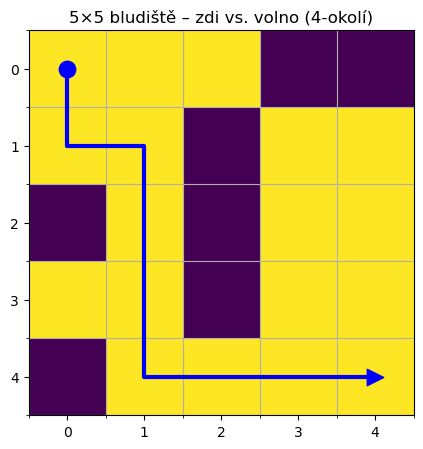

In [5]:
# --- Vizualizace: čtverečky (mřížka), 1=volno, 0=zeď ---
fig = plt.figure(figsize=(5, 5))
plt.imshow(maze_img, interpolation="nearest")
plt.xticks(range(N))
plt.yticks(range(N))
# Zobrazíme mřížkovou síť pro lepší čitelnost buněk
plt.xticks(np.arange(-.5, N, 1), minor=True)
plt.yticks(np.arange(-.5, N, 1), minor=True)
plt.grid(which="minor")

# Start a cíl (numpy indexování: (r,c) -> (y,x))
plt.scatter(START[1], START[0], s=140, marker="o", color='blue')
plt.scatter(GOAL[1],  GOAL[0],  s=140, marker=">", color='blue')

# Vykreslení nalezené cesty po středech buněk
ys = [r for r, c in path]
xs = [c for r, c in path]
plt.plot(xs, ys, linewidth=3, color='blue')

plt.title("5×5 bludiště – zdi vs. volno (4-okolí)")
plt.show()


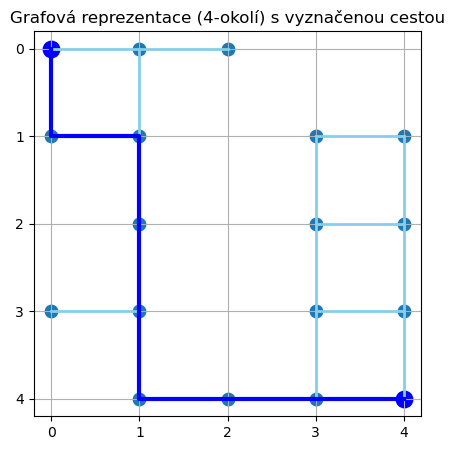

Počet uzlů: 18, počet hran: 21
Cesta (r,c): [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4)]


In [6]:
# --- Grafová reprezentace: uzly = volná pole, hrany = 4-okolí ---
nodes, edges = grid_to_graph(grid)

fig = plt.figure(figsize=(5, 5))
# Uzly zakreslíme do středu buněk (x = sloupec c, y = řádek r)
xs_nodes = [c for _, c in nodes]
ys_nodes = [r for r, _ in nodes]
plt.scatter(xs_nodes, ys_nodes, s=80)

# Hrany kreslíme jako spojnice středů sousedních buněk
for (r1, c1), (r2, c2) in edges:
    plt.plot([c1, c2], [r1, r2], linewidth=2, c="skyblue")

# Zvýrazníme stejnou nejkratší cestu, jakou našlo BFS v mřížce
xs = [c for _, c in path]
ys = [r for r, _ in path]
plt.plot(xs, ys, linewidth=3, color='blue')

# Start a cíl
plt.scatter(START[1], START[0], s=140, marker="o", color='blue')
plt.scatter(GOAL[1],  GOAL[0],  s=140, marker="o", color='blue')

plt.xticks(range(N))
plt.yticks(range(N))
plt.gca().invert_yaxis()  # Otočí osu Y, aby vizuálně odpovídala matici (řádky shora dolů)
plt.grid(True)
plt.title("Grafová reprezentace (4-okolí) s vyznačenou cestou")
plt.show()

print(f"Počet uzlů: {len(nodes)}, počet hran: {len(edges)}")
print("Cesta (r,c):", path)


In [7]:
# --- Volitelný export obrázků ---
if EXPORT_PNG:
    # Bludiště (PNG)
    fig = plt.figure(figsize=(5, 5))
    plt.close(fig)

    # Graf (PNG)
    fig = plt.figure(figsize=(5, 5))
    plt.close(fig)
    print("Uloženo: maze_5x5.png, maze_graph_5x5.png")
